<a href="https://colab.research.google.com/github/CatherineDemian/Face-recognition-autoencoders-/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing

In [ ]:
import os
import shutil
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import cv2
from sklearn.metrics import accuracy_score
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.losses import mse
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

zip_path = '/content/drive/My Drive/archive.zip'
print(os.path.exists(zip_path))  # This should return True if the file exists


True


In [ ]:
# Extract dataset
def extract_dataset(zip_path, output_path):
    """
    Extract the dataset from a zip file to the given output path.

    Parameters:
    - zip_path: Path to the zip file containing the dataset.
    - output_path: Directory where the extracted files will be saved.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_path)

zip_path = '/content/drive/My Drive/archive.zip'
data_path = '/content/casia_dataset'
output_path = '/content/split_dataset'

# Extract and load dataset
extract_dataset(zip_path, data_path)

# Full data

In [ ]:

# Function to get image paths and labels, skipping the root folder
def load_images_and_labels(data_path):
    image_paths, labels = [], []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                image_paths.append(os.path.join(root, file))
                labels.append(os.path.basename(root))  # Folder name as label
    print(f"Found {len(image_paths)} images across {len(set(labels))} labels.")
    return image_paths, labels

# Get image paths and labels, skipping the root folder
image_paths, labels = load_images_and_labels(data_path)

# Split the dataset into train, validation, and test sets
train_files, temp_files, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Function to copy files to split directories
def copy_files(file_paths, file_labels, split_name, output_path):
    for file_path, label in zip(file_paths, file_labels):
        split_class_dir = f"{output_path}/{split_name}/{label}"
        os.makedirs(split_class_dir, exist_ok=True)
        shutil.copy(file_path, f"{split_class_dir}/{os.path.basename(file_path)}")


# Copy dataset splits
copy_files(train_files, train_labels, "train", output_path)
copy_files(val_files, val_labels, "val", output_path)
copy_files(test_files, test_labels, "test", output_path)

# Verify the splits
for split in ["train", "val", "test"]:
    split_dir = os.path.join(output_path, split)
    print(f"{split.capitalize()} has {len(os.listdir(split_dir))} classes.")


Found 20197 images across 200 labels.
Train has 200 classes.
Val has 200 classes.
Test has 200 classes.


# 100 Classes

In [ ]:


# Function to get image paths and labels, skipping the root folder
def load_images_and_labels(data_path, num_classes=None):
    image_paths, labels = [], []
    label_count = {}  # To keep track of the number of classes

    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                label = os.path.basename(root)  # Folder name as label
                # Only add files if the label count is within the limit
                if num_classes is None or label_count.get(label, 0) < num_classes:
                    image_paths.append(os.path.join(root, file))
                    labels.append(label)
                    label_count[label] = label_count.get(label, 0) + 1

    # Reduce to only the first `num_classes` unique classes if specified
    if num_classes:
        unique_labels = sorted(set(labels))[:num_classes]
        filtered_data = [(path, lbl) for path, lbl in zip(image_paths, labels) if lbl in unique_labels]
        image_paths, labels = zip(*filtered_data)

    print(f"Found {len(image_paths)} images across {len(set(labels))} labels.")
    return list(image_paths), list(labels)

# Specify the number of classes to keep
NUM_CLASSES = 100

# Get image paths and labels, limiting to NUM_CLASSES
image_paths, labels = load_images_and_labels(data_path, num_classes=NUM_CLASSES)

# Split the dataset into train, validation, and test sets
train_files, temp_files, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Function to copy files to split directories
def copy_files(file_paths, file_labels, split_name, output_path):
    for file_path, label in zip(file_paths, file_labels):
        split_class_dir = f"{output_path}/{split_name}/{label}"
        os.makedirs(split_class_dir, exist_ok=True)
        shutil.copy(file_path, f"{split_class_dir}/{os.path.basename(file_path)}")

# Output path for the split datasets
output_path = "output_dataset"

# Copy dataset splits
copy_files(train_files, train_labels, "train", output_path)
copy_files(val_files, val_labels, "val", output_path)
copy_files(test_files, test_labels, "test", output_path)

# Verify the splits
for split in ["train", "val", "test"]:
    split_dir = os.path.join(output_path, split)
    class_dirs = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
    print(f"{split.capitalize()} has {len(class_dirs)} classes.")


Found 10000 images across 100 labels.
Train has 100 classes.
Val has 100 classes.
Test has 100 classes.


### No of samples per split

In [ ]:
def count_samples_in_split(split_name):
    split_dir = os.path.join(output_path, split_name)
    class_counts = {}
    total_samples = 0

    for class_dir in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_dir)
        if os.path.isdir(class_path):  # Ensure it's a directory
            num_images = len(os.listdir(class_path))
            class_counts[class_dir] = num_images
            total_samples += num_images

    return class_counts, total_samples

# Count samples for train, validation, and test
for split in ["train", "val", "test"]:
    class_counts, total_samples = count_samples_in_split(split)
    print(f"\n{split.capitalize()} split:")
    print(f"Total samples: {total_samples}")
    print(f"Samples per class:")
    for class_name, count in class_counts.items():
        print(f"  Class {class_name}: {count} samples")


Train split:
Total samples: 7000
Samples per class:
  Class 000008: 70 samples
  Class 000178: 70 samples
  Class 000083: 70 samples
  Class 000056: 70 samples
  Class 000057: 70 samples
  Class 000016: 70 samples
  Class 000073: 70 samples
  Class 000023: 70 samples
  Class 000136: 70 samples
  Class 000012: 70 samples
  Class 000069: 70 samples
  Class 000176: 70 samples
  Class 000085: 70 samples
  Class 000149: 70 samples
  Class 000200: 70 samples
  Class 000129: 70 samples
  Class 000198: 70 samples
  Class 000214: 70 samples
  Class 000034: 70 samples
  Class 000166: 70 samples
  Class 000014: 70 samples
  Class 000054: 70 samples
  Class 000170: 70 samples
  Class 000130: 70 samples
  Class 000026: 70 samples
  Class 000209: 70 samples
  Class 000010: 70 samples
  Class 000081: 70 samples
  Class 000128: 70 samples
  Class 000203: 70 samples
  Class 000003: 70 samples
  Class 000234: 70 samples
  Class 000037: 70 samples
  Class 000187: 70 samples
  Class 000088: 70 samples
  

In [ ]:

# Normalize images
def normalize_image(img):
    mean = np.mean(img, axis=(0, 1,), keepdims=True)
    std = np.std(img, axis=(0, 1), keepdims=True)
    return (img - mean) / (std + 1e-7)


In [ ]:
def load_and_normalize_dataset(split_dir):
    images, labels = [], []
    for label in sorted(os.listdir(split_dir)):
        label_dir = f"{split_dir}/{label}"
        for file_name in sorted(os.listdir(label_dir)):
            img = cv2.imread(f"{label_dir}/{file_name}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (64, 64))  # Resize images for consistency
            images.append(normalize_image(img))
            labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
  # Normalize and visualize dataset
train_images, train_labels = load_and_normalize_dataset(f"{output_path}/train")
val_images, val_labels = load_and_normalize_dataset(f"{output_path}/val")
test_images, test_labels = load_and_normalize_dataset(f"{output_path}/test")


In [ ]:
train_images.shape

(7000, 64, 64, 3)

## Visualize Normalization

In [ ]:
def visualize_normalization(original_img, normalized_img):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[1].imshow((normalized_img - normalized_img.min()) / (normalized_img.max() - normalized_img.min()))  # Rescale for visualization
    axes[1].set_title("Normalized Image (Per-Channel)")
    plt.show()


In [ ]:
def process_and_visualize(dataset_files, title):
    print(f"Visualizing {title} set:")
    for img_path in dataset_files[:5]:  # Visualize the first 5 images
        original_img = cv2.imread(img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        normalized_img = normalize_image(original_img)
        visualize_normalization(original_img, normalized_img)

Visualizing Train set:


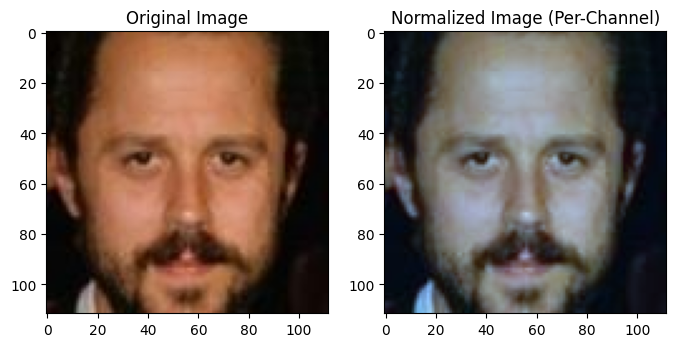

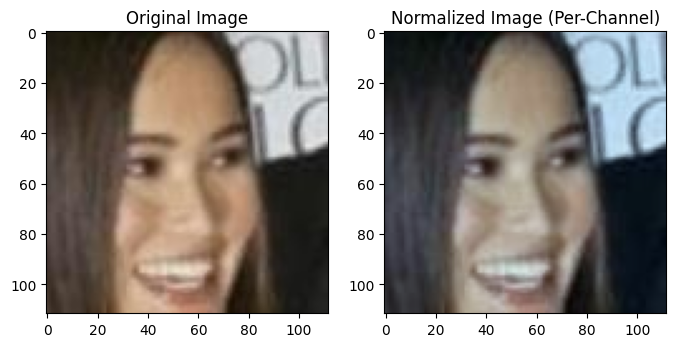

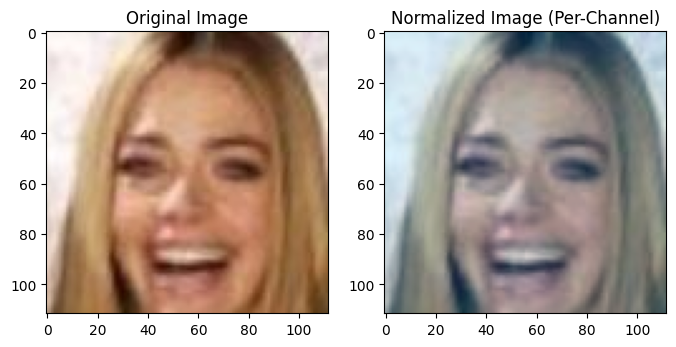

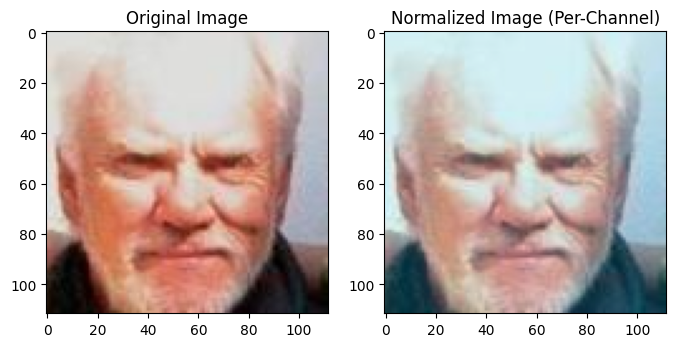

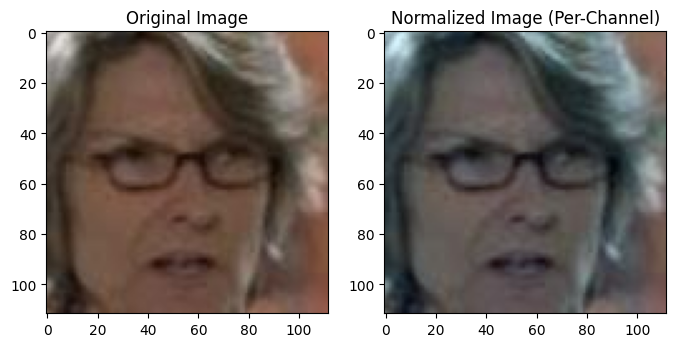

Visualizing Validation set:


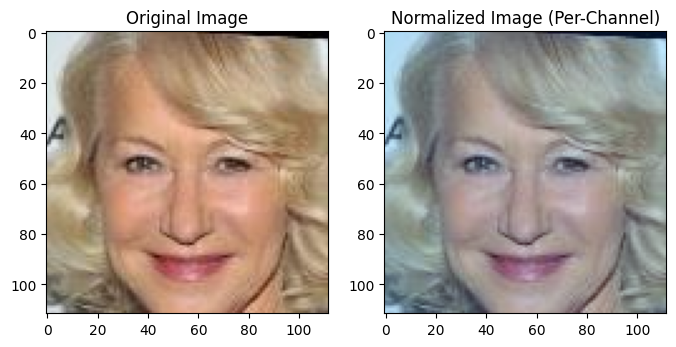

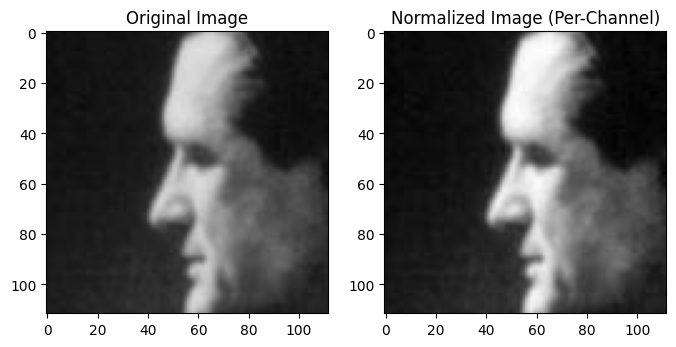

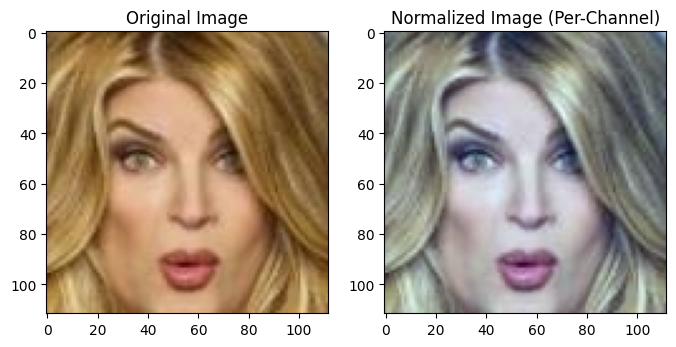

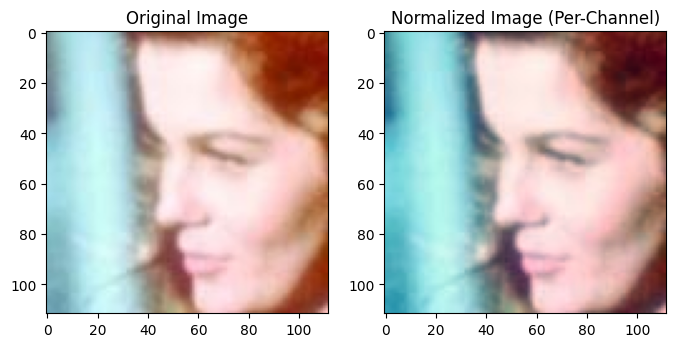

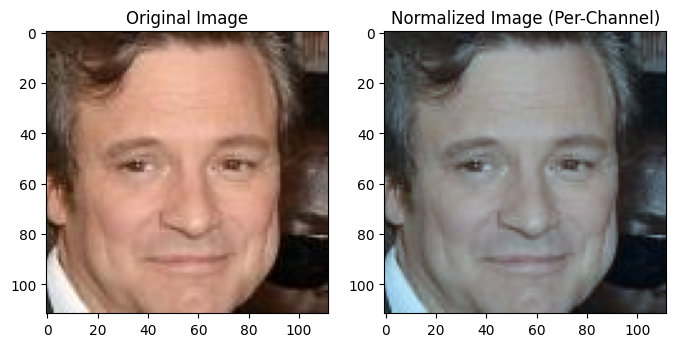

Visualizing Test set:


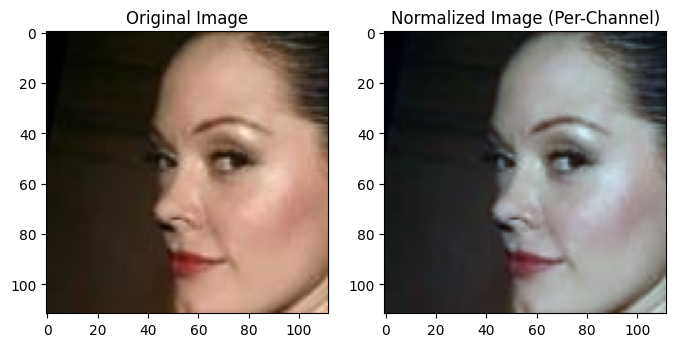

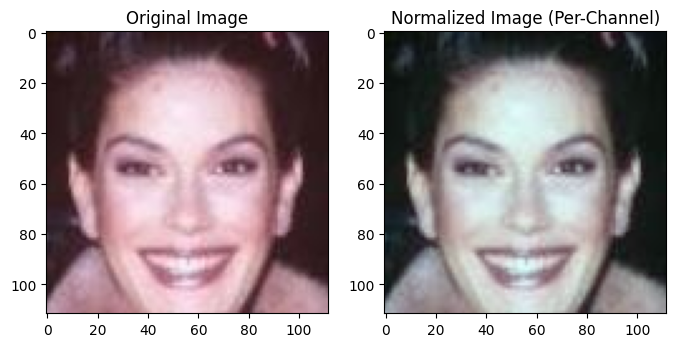

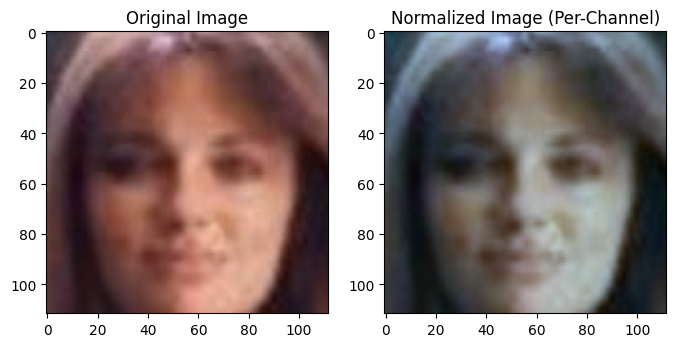

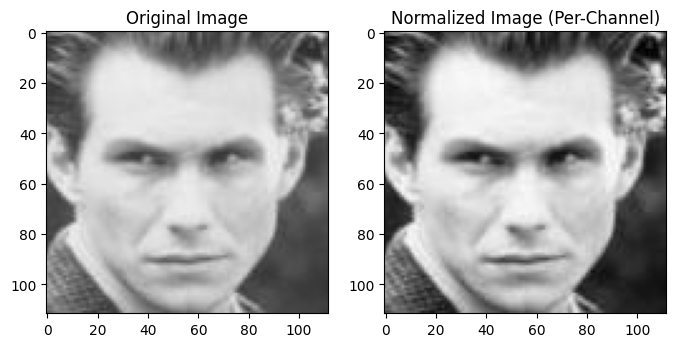

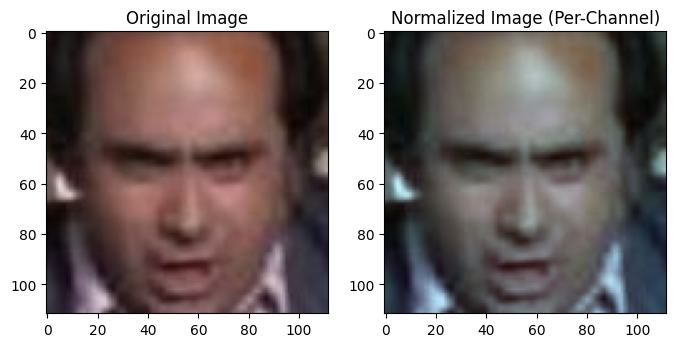

In [ ]:
process_and_visualize(train_files, "Train")
process_and_visualize(val_files, "Validation")
process_and_visualize(test_files, "Test")

In [ ]:
def normalize_image(img):
    mean = np.mean(img, axis=(0, 1), keepdims=True)
    std = np.std(img, axis=(0, 1), keepdims=True)
    return (img - mean) / (std + 1e-7)

# Load and normalize the dataset
def load_and_normalize_dataset(split_dir):
    images, labels = [], []
    for label in sorted(os.listdir(split_dir)):
        label_dir = f"{split_dir}/{label}"
        for file_name in sorted(os.listdir(label_dir)):
            img = cv2.imread(f"{label_dir}/{file_name}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (64, 64))  # Resize images for consistency
            images.append(normalize_image(img))
            labels.append(label)
    return np.array(images), np.array(labels)

    # Visualize data before and after normalization
def visualize_data(images, title):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow((images[i]-images[i].min())/(images[i].max()-images[i].min()))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

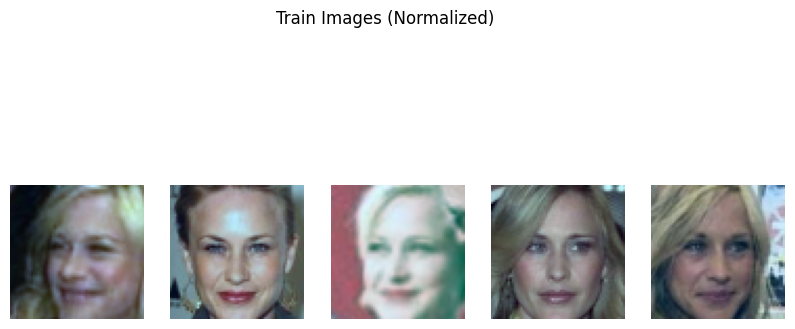

In [ ]:
# Normalize and visualize dataset
train_images, train_labels = load_and_normalize_dataset(f"{output_path}/train")
val_images, val_labels = load_and_normalize_dataset(f"{output_path}/val")
test_images, test_labels = load_and_normalize_dataset(f"{output_path}/test")
visualize_data(train_images, "Train Images (Normalized)")

# Numpy To tensors

In [ ]:
train_images_tensors = tf.convert_to_tensor(train_images, dtype=tf.float32)
val_images_tensors = tf.convert_to_tensor(val_images, dtype=tf.float32)
test_images_tensors = tf.convert_to_tensor(test_images, dtype=tf.float32)

In [ ]:
train_labels_int = np.array([int(label) for label in train_labels], dtype=np.int32)
test_labels_int = np.array([int(label) for label in test_labels], dtype=np.int32)
val_labels_int = np.array([int(label) for label in val_labels], dtype=np.int32)

In [ ]:
train_images_label_tensors = tf.convert_to_tensor(train_labels_int, dtype=tf.int32)
val_images_labe_tensors = tf.convert_to_tensor(test_labels_int, dtype=tf.int32)
test_images_label_tensors = tf.convert_to_tensor(val_labels_int, dtype=tf.int32)

In [ ]:
unique_values = np.unique(test_images)
print(unique_values)

[-6.59325745 -6.49355164 -6.39384584 ... 11.6890479  12.92876101
 13.23868929]


In [ ]:
unique_values = np.unique(test_labels_int)
print(unique_values)

[  1   3   6   8   9  10  12  14  16  18  19  21  22  23  24  25  26  27
  31  32  33  34  35  36  37  38  39  41  43  46  47  51  54  56  57  58
  61  68  69  73  74  76  79  81  83  84  85  86  88  97 101 104 105 114
 128 129 130 136 137 138 145 147 148 149 152 157 165 166 168 169 170 172
 173 174 176 178 184 186 187 190 193 194 195 196 198 199 200 203 206 209
 214 217 220 221 229 231 234 237 238 240]


# Encoder Decoder


# VAE

In [ ]:


# Your model creation function
def create_vae_model(latent_dim, layer_nodes):
    # Encoder
    input_img = tf.keras.Input(shape=(64, 64, 3), name="encoder_input")
    x = tf.keras.layers.Flatten()(input_img)
    for nodes in layer_nodes:
        x = tf.keras.layers.Dense(nodes, activation='relu', kernel_initializer='he_normal')(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

    # Reparameterization trick
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
        return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

    z = tf.keras.layers.Lambda(sampling, name="z")([z_mean, z_log_var])
    encoder = tf.keras.Model(input_img, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
    x = tf.keras.layers.Dense(layer_nodes[-1], activation='relu', kernel_initializer='he_normal')(latent_inputs)
    for nodes in reversed(layer_nodes[:-1]):
        x = tf.keras.layers.Dense(nodes, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dense(64 * 64 * 3, activation='linear')(x)
    decoded = tf.keras.layers.Reshape((64, 64, 3))(x)
    decoder = tf.keras.Model(latent_inputs, decoded, name="decoder")

    # VAE Loss Layer
    class VAELossLayer(tf.keras.layers.Layer):
        def call(self, inputs):
            input_img, decoded, z_mean, z_log_var = inputs
            input_flat = tf.keras.layers.Flatten()(input_img)
            decoded_flat = tf.keras.layers.Flatten()(decoded)
            reconstruction_loss = tf.reduce_mean(tf.square(input_flat - decoded_flat), axis=-1)
            kl_weight = 0.1
            kl_loss = kl_weight * (-0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
            total_loss = reconstruction_loss + kl_loss
            self.add_loss(total_loss)
            return decoded

    # VAE Model
    vae_outputs = decoder(encoder(input_img)[2])  # Use the z (latent space) from encoder
    vae_outputs = VAELossLayer()([input_img, vae_outputs, z_mean, z_log_var])
    vae = tf.keras.Model(input_img, vae_outputs, name="vae")
    vae.summary()
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0))

    return vae, encoder

# Example function for performing cross-validation
def cross_validate_vae(data, latent_dim, layer_nodes, k):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_no = 1
    fold_metrics = []

    for train_idx, val_idx in kfold.split(data):
        print(f"Training fold {fold_no}/{k}...")

        # Split into training and validation sets
        train_data, val_data = data[train_idx], data[val_idx]

        vae, _ = create_vae_model(latent_dim, layer_nodes)

        # Train the model
        history = vae.fit(
            train_data,
            train_data,
            epochs=10,
            batch_size=8,
            validation_data=(val_data, val_data),
            verbose=1
        )

        # Collect metrics for this fold
        fold_metrics.append(history.history)
        fold_no += 1

    return fold_metrics



## Final Try

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dynamic function to calculate node distribution
def generate_layer_nodes(total_nodes, num_layers):
    nodes = []
    for _ in range(num_layers):
        nodes.append(int(total_nodes))
        total_nodes /= 2
    return nodes

# Options for number of layers and starting nodes
num_layers_options = [ 3, 4,5]  # Number of layers to try
starting_nodes_options = [256, 512, 1024]  # Starting nodes for the first layer

# To store results
results = []
best_config = None
best_val_loss = np.inf  # Initialize the best validation loss to a very high value
latent_dim = 4  # Latent space dimensions
k = 3  # Number of cross-validation folds

for num_layers in num_layers_options:
    for starting_nodes in starting_nodes_options:
        layer_nodes = generate_layer_nodes(starting_nodes, num_layers)
        print(f"Training with num_layers={num_layers}, layer_nodes={layer_nodes}")

        # Perform cross-validation (replace with your cross-validation function)
        fold_metrics = cross_validate_vae(train_images, latent_dim, layer_nodes, k)

        # Calculate average validation loss across all folds
        avg_val_loss = np.mean([metrics['val_loss'][-1] for metrics in fold_metrics])
        print(f"Avg Validation Loss for num_layers={num_layers}, layer_nodes={layer_nodes}: {avg_val_loss:.4f}")

        # Update the best configuration if this one is better
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_config = {
                "num_layers": num_layers,
                "layer_nodes": layer_nodes,
                "avg_val_loss": avg_val_loss,
            }

        # Collect and plot results
        results.append((num_layers, layer_nodes, fold_metrics))
        for fold_no, metrics in enumerate(fold_metrics, start=1):
            plt.plot(metrics['loss'], label=f'Train Loss (Fold {fold_no}, Layers={num_layers})')
            plt.plot(metrics['val_loss'], label=f'Val Loss (Fold {fold_no}, Layers={num_layers})')

# Finalize the plot
plt.title('Loss vs. Iterations for Different Configurations')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Summary of results
for num_layers, layer_nodes, fold_metrics in results:
    print(f"Config: num_layers={num_layers}, layer_nodes={layer_nodes}")
    for fold_no, metrics in enumerate(fold_metrics, start=1):
        print(f" Fold {fold_no}: Final Train Loss = {metrics['loss'][-1]:.4f}, Final Val Loss = {metrics['val_loss'][-1]:.4f}")

# Output the best configuration
print("\nBest Configuration:")
print(f"Number of Layers: {best_config['num_layers']}")
print(f"Nodes per Layer: {best_config['layer_nodes']}")
print(f"Average Validation Loss: {best_config['avg_val_loss']:.4f}")

# Use the best configuration for training the final model
final_best_config = best_config


Training with num_layers=3, layer_nodes=[256, 128, 64]


NameError: name 'cross_validate_vae' is not defined

In [ ]:
final_best_config = best_config

NameError: name 'best_config' is not defined

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Assuming create_vae_model is defined and works as expected
latent_dim = 32
best_layer_nodes = final_best_config['layer_nodes']
vae, encoder = create_vae_model(latent_dim, best_layer_nodes)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = vae.fit(
    train_images,
    train_images,  # Autoencoder output is the input
    epochs=100,
    batch_size=8,
    validation_data=(val_images, val_images),
    callbacks=[early_stopping]
)

plot_loss(history)

NameError: name 'final_best_config' is not defined

In [ ]:

decoded_images = vae.predict(test_images)
plot_reconstruction(test_images, decoded_images)

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


NameError: name 'plot_reconstruction' is not defined

In [ ]:

# Extract latent space representations
train_latent = encoder.predict(train_images)
val_latent = encoder.predict(val_images)
test_latent = encoder.predict(test_images)

# Visualize latent space (optional)
train_latent = np.array(encoder.predict(train_images))  # Convert to NumPy arrays
val_latent = np.array(encoder.predict(val_images))      # Convert to NumPy arrays
test_latent = np.array(encoder.predict(test_images))    # Convert to NumPy arrays

# Visualize latent space (optional)
visualize_latent_space(train_latent[0], labels=train_labels_int)
# Assuming euclidean_distance_classifier_with_centroids returns a tuple
predictions, accuracy = euclidean_distance_classifier_with_centroids(train_latent[0], train_labels_int, val_latent[0], val_labels_int)

# Now predictions is the predicted class labels and accuracy is the accuracy value
print(f"Predictions: {predictions}")
print(f"Accuracy: {accuracy}")


# Print classification accuracy
accuracy = accuracy_score(val_labels_int, predictions)
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

# Visualize latent space with true and predicted labels
visualize_latent_space_with_predictions(val_latent[0], true_labels=val_labels_int, predicted_labels=predictions)
# Example usage
n = 10  # Number of images to display
plot_predictions_with_images(test_images[:n], val_labels_int[:n], predictions[:n])

NameError: name 'encoder' is not defined

In [ ]:
train_labels_int.shape

(7000,)

In [ ]:
print(train_labels_int.dtype)

int32


In [ ]:
print(np.unique(train_labels_int))  # Check unique label values


[  1   3   6   8   9  10  12  14  16  18  19  21  22  23  24  25  26  27
  31  32  33  34  35  36  37  38  39  41  43  46  47  51  54  56  57  58
  61  68  69  73  74  76  79  81  83  84  85  86  88  97 101 104 105 114
 128 129 130 136 137 138 145 147 148 149 152 157 165 166 168 169 170 172
 173 174 176 178 184 186 187 190 193 194 195 196 198 199 200 203 206 209
 214 217 220 221 229 231 234 237 238 240]


In [ ]:
# Extract latent space representations
train_latent = encoder.predict(train_images)
val_latent = encoder.predict(val_images)
test_latent = encoder.predict(test_images)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
type(train_latent)  # Should be (7000, latent_dim)

list

In [ ]:
train_latent = np.array(train_latent)
print(train_latent.shape)

(3, 7000, 16)
